# Analyse par composantes principales

Inspiré de [PyCon 2015 Scikit-learn Tutorial](https://github.com/jakevdp/sklearn_pycon2015) par Jake VanderPlas


Jusqu'à présent, nous avons étudié de manière approfondie les estimateurs d'apprentissage supervisé: ces estimateurs qui prédisent des étiquettes en fonction de données d'apprentissage étiquetées.
Nous commençons ici à examiner plusieurs estimateurs non supervisés, qui peuvent mettre en évidence des aspects intéressants des données sans faire référence à des étiquettes connues.

Dans cette section, nous explorons l’un des algorithmes non supervisés les plus largement utilisés, l’analyse en composantes principales (ACP/PCA).
PCA est  un algorithme de réduction de dimensionnalité, mais il peut également être utile en tant qu'outil de visualisation, de filtrage du bruit, d'extraction de caractéristiques, et bien plus encore.

Nous commençons par les importations standard:

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## PCA
L’analyse en composantes principales est une méthode rapide et flexible non supervisée pour la réduction de la dimensionnalité des donnée. Son comportement est le plus facile à visualiser en consultant un jeu de données bidimensionnel.
Considérez les 200 points suivants:

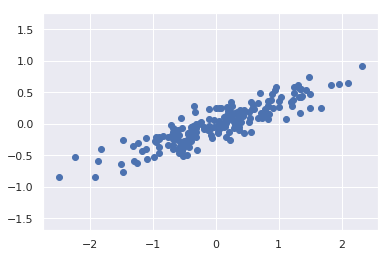

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

# À l’œil, il est clair qu’il existe une relation presque linéaire entre les variables x et y.
Cela rappelle les données de régression linéaire que nous avons explorées dans, mais le problème posé ici est légèrement différent: plutôt que d'essayer de *prévoir* les valeurs y à partir de x valeurs, le problème d’apprentissage non supervisé tente d’en savoir plus sur la *relation* entre les valeurs x et y.

Dans l'analyse en composantes principales, cette relation est quantifiée en recherchant une liste des *axes principaux* dans les données et en utilisant ces axes pour décrire l'ensemble de données.
En utilisant l’estimateur `` PCA`` de Scikit-Learn, nous pouvons calculer ceci comme suit:

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

L'ajustement apprend certaines quantités à partir des données, principalement les "composants" et la "variance expliquée":

In [4]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [5]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


Pour voir ce que signifient ces nombres, visualisons-les sous forme de vecteurs sur les données d'entrée, en utilisant les "composants" pour définir la direction du vecteur et la "variance expliquée" pour définir la longueur au carré du vecteur:

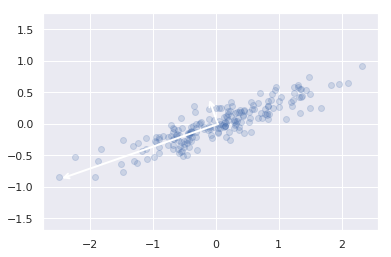

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

Ces vecteurs représentent les axes principaux  des données et la longueur du vecteur indique à quel point cet axe est "important" dans la description de la distribution des données. Plus précisément, il s'agit d'une mesure de la variance des données lorsqu'elles sont projetées. sur cet axe. La projection de chaque point de données sur les axes principaux sont les "composantes principales" des données.
Si nous traçons ces composants principaux à côté des données d'origine, nous voyons les tracés présentés ici:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.09-PCA-rotation.png?raw=1)

Cette transformation des axes de données en axes principaux est une * transformation affine *, ce qui signifie fondamentalement qu'elle est composée d'une translation, d'une rotation et d'une mise à l'échelle uniforme.

Bien que cet algorithme permettant de trouver les composants principaux puisse sembler être une simple curiosité mathématique, il s’avère avoir des applications très étendues dans le monde de l’apprentissage automatique et de l’exploration de données.


### PCA et réduction de la dimensionnalité

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:

In [0]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

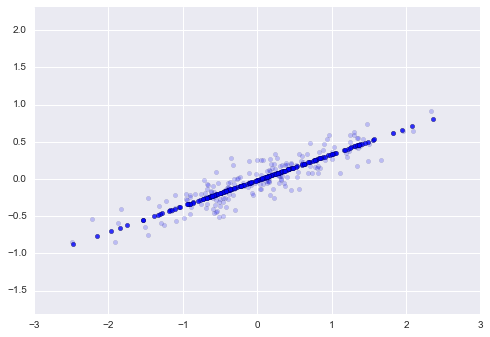

In [0]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version.
This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.
The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

### PCA for visualization: Hand-written digits

L'utilité de la réduction de dimensionnalité peut ne pas être entièrement évidente dans deux dimensions seulement, mais devient beaucoup plus claire lorsque l'on examine des données de grande dimension.
Pour voir cela, jetons un coup d'œil à l'application de la PCA aux données de chiffre, de type MNIST

In [7]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Ces données sont constituées d'images 8 × 8 pixels, ce qui signifie qu'elles sont à 64 dimensions.
Pour acquérir une certaine intuition dans les relations entre ces points, nous pouvons utiliser PCA pour les projeter dans un nombre de dimensions plus gérable, par exemple deux:

In [10]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


Nous pouvons maintenant tracer les deux premières composantes principales de chaque point pour en savoir plus sur les données:

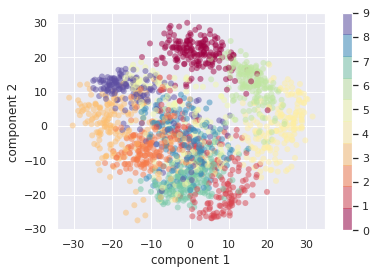

In [12]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Rappelez ce que ces composants signifient: les données complètes sont un nuage de points de 64 dimensions, et ces points sont la projection de chaque point de données le long des directions présentant la variance la plus grande.
Pour l'essentiel, nous avons trouvé l'étirement et la rotation optimaux dans un espace à 64 dimensions qui nous permet de voir la disposition des chiffres en deux dimensions, et ce, de manière non supervisée, c'est-à-dire sans référence aux étiquettes.

## Choisir le nombre de composants

Un élément essentiel de l’utilisation pratique de la PCA est la capacité d’estimer le nombre de composants nécessaires à la description des données.
Ceci peut être déterminé en regardant le ratio de variance expliquée *cumulée* en fonction du nombre de composantes:

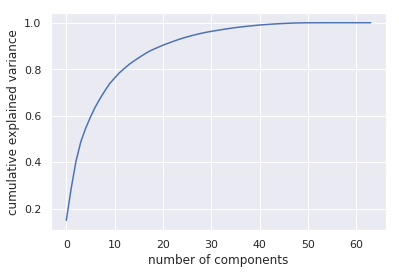

In [13]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Cette courbe quantifie la part de la variance totale à 64 dimensions contenue dans les premières composantes 𝑁. Par exemple, nous voyons qu'avec les chiffres, les 10 premiers composants contiennent environ 75% de la variance, alors qu'il vous faut environ 50 composants pour décrire près de 100% de la variance.
Nous voyons ici que notre projection bidimensionnelle perd beaucoup d'informations (mesurées par la variance expliquée) et qu'il nous faudrait environ 20 composants pour conserver 90% de la variance. L'examen de ce graphique pour rechercher un jeu de données de grande dimension peut vous aider à comprendre le niveau de redondance présent dans plusieurs observations.

## PCA comme filtrage du bruit

La PCA peut également servir d’approche de filtrage des données bruitées.
L'idée est la suivante: les composants dont la variance varie beaucoup plus que l'effet du bruit doivent être relativement peu affectés par le bruit.
Donc, si vous reconstruisez les données en utilisant uniquement le plus grand sous-ensemble de composants principaux, vous devriez préférer conserver le signal et éliminer le bruit.

Voyons à quoi cela ressemble avec les chiffres.
Commençons par tracer plusieurs données d'entrée sans bruit:

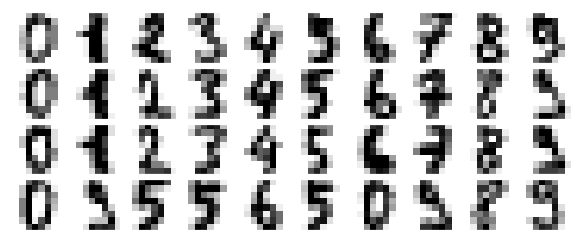

In [14]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Ajoutons maintenant du bruit aléatoire pour créer un jeu de données bruyant et re-tracez-le:

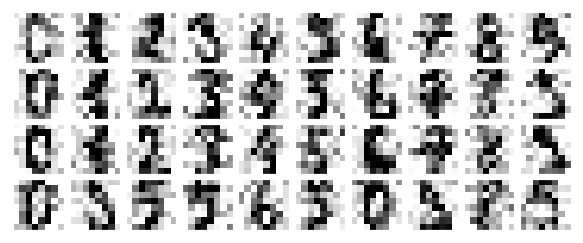

In [15]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

Il est clair à l'œil que les images sont bruyantes et contiennent des pixels parasites.
Formons un PCA sur les données bruitées en demandant à la projection de préserver 50% de la variance:

In [16]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Ici, 50% de la variance correspond à 12 composantes principales.
Maintenant, nous calculons ces composants, puis utilisons l'inverse de la transformation pour reconstruire les chiffres filtrés:

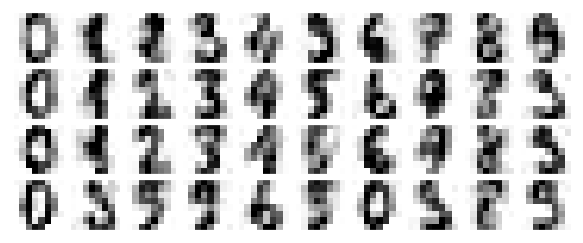

In [17]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

Cette propriété de préservation du signal / filtrage du bruit fait de la PCA une routine de sélection de fonctionnalités très utile. Par exemple, au lieu de former un classifieur sur des données de très grande dimension, vous pouvez plutôt former le classifieur sur la représentation de plus petite dimension, qui servira automatiquement à filtrer sur le bruit aléatoire dans les entrées.